<a href="https://colab.research.google.com/github/markpoxley/rrVAE-for-4D-STEM/blob/main/4D_STEM_EXPERIMENTV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

June 18, 2020

- rVAE on 4D STEM on graphene
- Original data by Ondrej Dyck
- Original analysis notebook by Rama Vasudevan and Mark Oxley
- rVAE in AtomAI by Maxim Ziatdinov
- workflow by Sergei V. Kalinin

July 7, 2020
-Tidied up by Mark Oxley

May 17, 2021
-Updated to use latest version of atomai by Mark Oxley
-Added extra descriptions.

Install atomai

In [1]:
!pip install -q atomai

     |████████████████████████████████| 133kB 14.5MB/s 
     |████████████████████████████████| 194kB 19.9MB/s 
     |████████████████████████████████| 870kB 21.4MB/s 


Import standard libraries

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

Import libraries to read in files from Nion UltraSTEM

In [3]:
import json
import zipfile
from pprint import pprint
from zipfile import ZipFile

Option to connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


gdowns for experimental data

4D graphene 64x64x256x256 1nmFOV.ndata1

In [4]:
!gdown https://drive.google.com/uc?id=1Y5UvHy9_dIWpBHYSsbt0I5z_hcxWldt4
!gdown https://drive.google.com/uc?id=1tSzTgy8lSn9a6-4Mm-fmpO2e4U1NC377

Downloading...
From: https://drive.google.com/uc?id=1Y5UvHy9_dIWpBHYSsbt0I5z_hcxWldt4
To: /content/4D graphene 64x64x256x256 1nmFOV.ndata1
1.07GB [00:11, 95.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tSzTgy8lSn9a6-4Mm-fmpO2e4U1NC377
To: /content/4D graphene HAADF 64x64 1nmFOV.ndata1
100% 23.1k/23.1k [00:00<00:00, 20.2MB/s]


4D graphene 3-fold Si 64x64x256x256 1nmFOV.ndata1

In [ ]:
!gdown https://drive.google.com/uc?id=1rmVvcVkv2JnGOkkMiOvJqHFNmhrZZWha
!gdown https://drive.google.com/uc?id=14UQGE55KLfEZ1cKFVi9R0fs-RcEd0IoW

4D graphene vacancy 64x64x256x256 1nmFOV.ndata1

In [ ]:
!gdown https://drive.google.com/uc?id=1HP_6DfrVsGjpDh5ueYVOPde7bqlE05ip
!gdown https://drive.google.com/uc?id=1CT_TTIgU_DqmU01MGC8IIsz7Dsm-utVj


First read in HAADF data to check the data

4D graphene HAADF 64x64 1nmFOV.ndata1
File Name                                             Modified             Size
metadata.json                                  2019-10-15 17:02:12         6393
data.npy                                       2019-10-15 17:02:12        16512


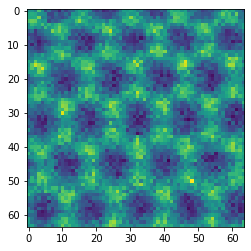

In [7]:
filein = '4D graphene HAADF 64x64 1nmFOV.ndata1'
print(filein)

zip_ref = zipfile.ZipFile(filein, 'r')
zipfile.ZipFile.printdir(zip_ref)
zip_ref.extractall()
zip_ref.close()

# load the metadata
with open('metadata.json') as f:
    metadata = json.load(f)
#Option to print metadata
#pprint(metadata)

#load the associated image and display it
HAADF = np.load('data.npy')
plt.imshow(HAADF)



Now read in CBEDs

In [8]:
filein = '4D graphene 64x64x256x256 1nmFOV.ndata1'
print(filein)

zip_ref = zipfile.ZipFile(filein, 'r')
zipfile.ZipFile.printdir(zip_ref)
zip_ref.extractall()
zip_ref.close()

# load the metadata
with open('metadata.json') as f:
    metadata = json.load(f)
## option to print metadata
#pprint(metadata)

#load the associated image and display it
CBEDS = np.load('data.npy')
print(CBEDS.shape)


4D graphene 64x64x256x256 1nmFOV.ndata1
File Name                                             Modified             Size
metadata.json                                  2019-10-15 17:03:28         1265
data.npy                                       2019-10-15 17:03:34   1073741952
(64, 64, 256, 256)


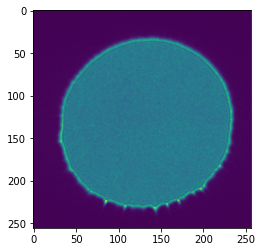

In [9]:
plt.imshow(CBEDS[0,0,:,:])

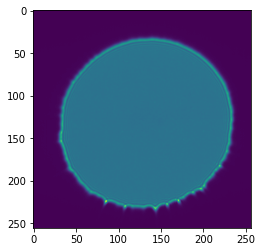

In [10]:
CBED_mean = CBEDS.mean(axis = (0,1))
plt.imshow(CBED_mean)

Try subtracting the mean to clean up the aperture

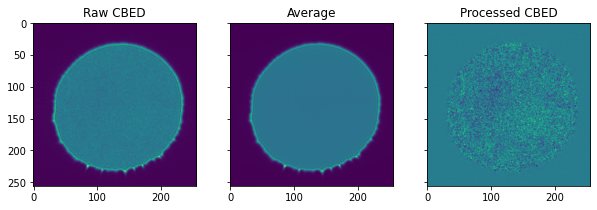

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
ax[0].set_title('Raw CBED')
comx = ax[0].imshow(CBEDS[0,0,:,:])
ax[1].set_title('Average')
comy = ax[1].imshow(CBED_mean)
ax[2].set_title('Processed CBED')
commag = ax[2].imshow(CBEDS[0,0,:,:]-CBED_mean)


64 64 256 256


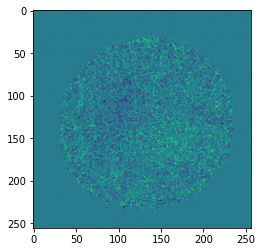

In [12]:
nysample, nxsample, nopiyout, nopixout = CBEDS.shape 
print(nysample, nxsample, nopiyout, nopixout)
# Subtract average
CBEDS = CBEDS - CBEDS.mean(axis = (0,1))
plt.imshow(CBEDS[0,0,:,:])


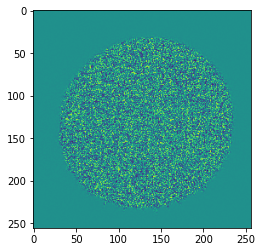

In [13]:
CBED_mean = CBEDS.mean(axis = (0,1))
plt.imshow(CBED_mean)


Reduce size of input data a managable size

1203.332275390625 -1018.6256103515625


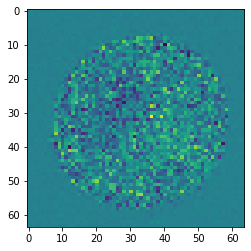

In [14]:
import cv2
# specify new size
nycrop = 64
nxcrop = 64
CBED_array = np.zeros((nysample, nxsample, nycrop, nxcrop))

for i in range(nysample):
  for j in range(nxsample):
    dst = cv2.resize(CBEDS[i,j,:,:], (nycrop,nxcrop), interpolation=cv2.INTER_CUBIC)
    CBED_array[i,j,:,:] = dst

# Normalize and reshape
CBED_max = CBED_array.max()
CBED_min = CBED_array.min()
print(CBED_max, CBED_min)
# DO NOT renormalize at this stage
#CBED_array = (CBED_array.reshape(nysample*nxsample, nycrop,nxcrop)-CBED_min)/(CBED_max-CBED_min)

plt.imshow(CBED_array[0,0, :,:])

#set pca array if pca is to run second after rebinning
PCA_array = CBED_array

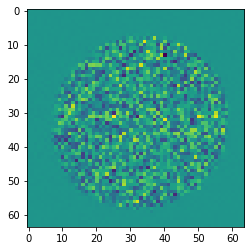

In [15]:
CBED_mean = CBED_array.mean(axis = (0,1))
plt.imshow(CBED_mean)


Apply PCA to remove some of the noise

64 64 64 64


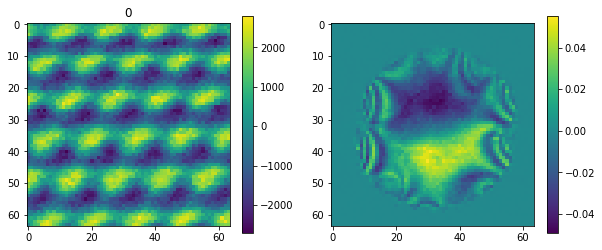

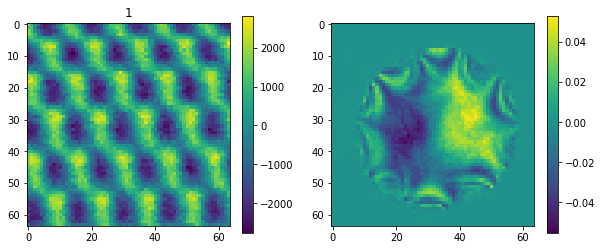

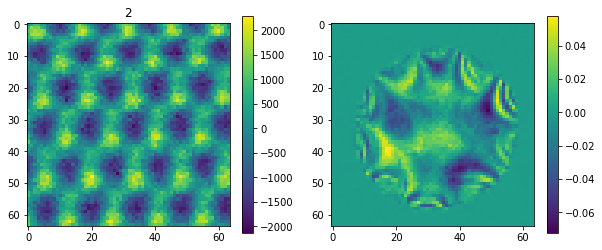

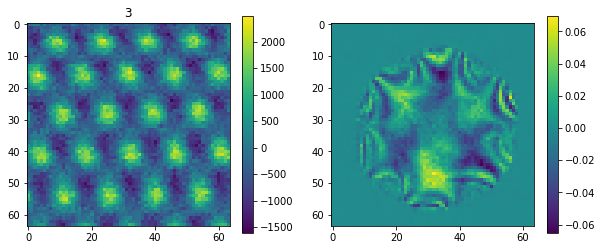

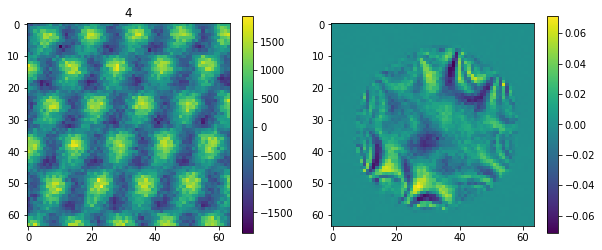

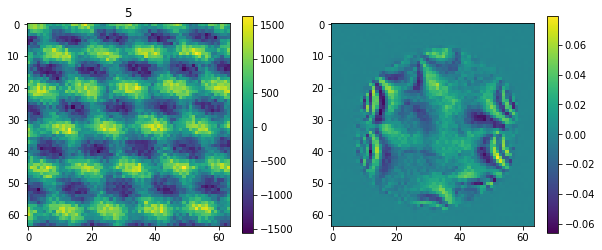

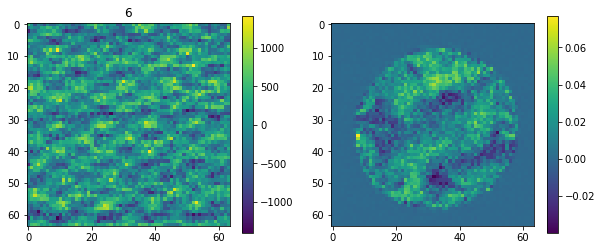

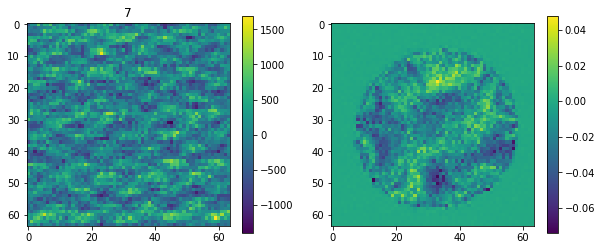

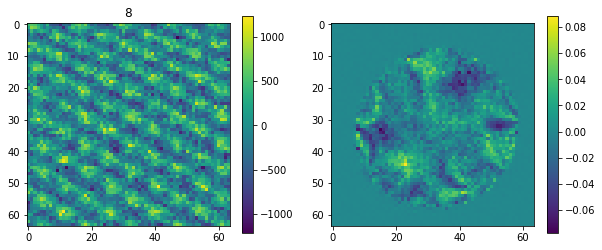

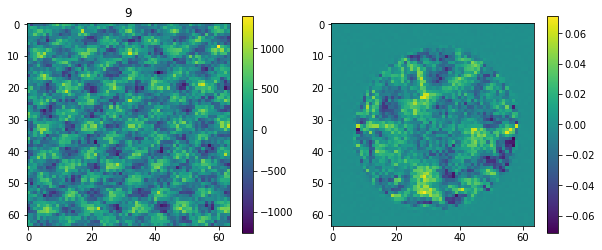

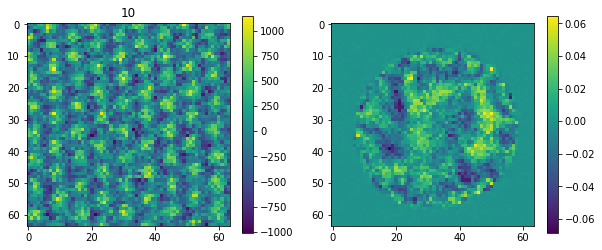

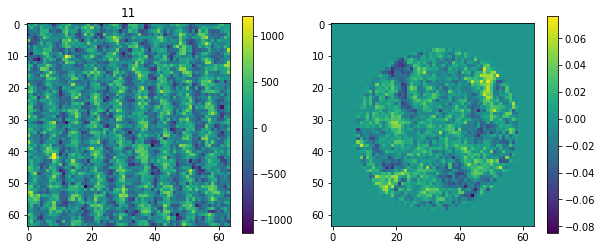

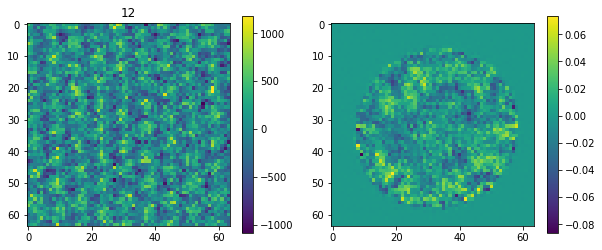

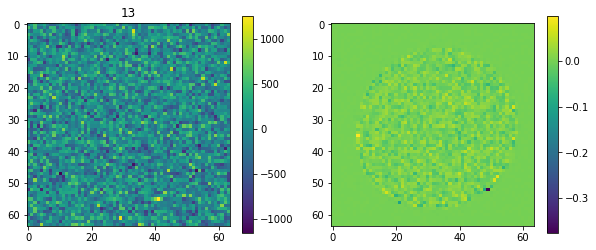

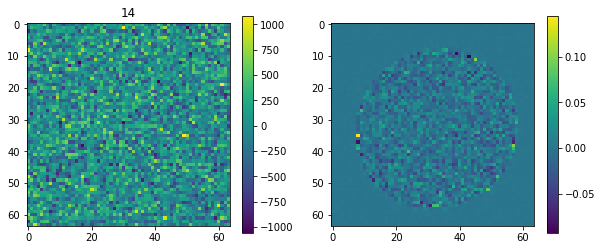

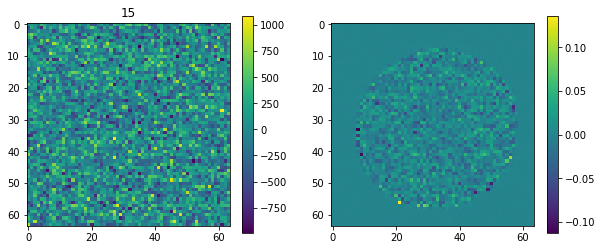

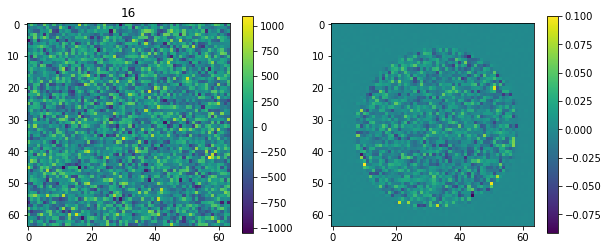

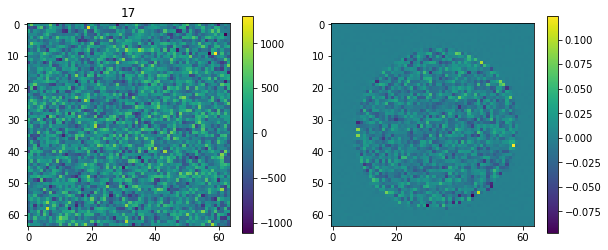

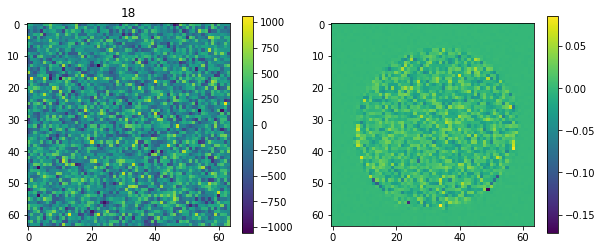

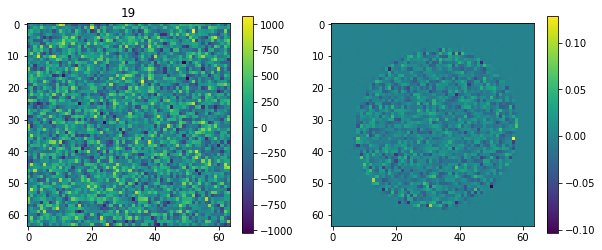

In [16]:
pca=PCA(20)
nysample, nxsample, nopiy, nopix = PCA_array.shape
print(nysample,nxsample,nopiy,nopix)
Y=pca.fit_transform(PCA_array.reshape(nysample*nxsample,nopiy*nopix))
for i in range(pca.n_components_):
    f,ax=plt.subplots(1,2,figsize=(10,10))
    ax[0].set_title(i)
    tmp = ax[0].imshow(Y[:,i].reshape(nysample,nxsample))
    plt.colorbar(tmp, ax = ax[0], shrink = 0.4)
    tmp = ax[1].imshow(pca.components_[i].reshape(nopiy,nopix))
    plt.colorbar(tmp, ax = ax[1], shrink = 0.4)
    plt.show()

Set some components to zero and reconstruct the data set.

In [17]:
# let's set some components to zero.
print(Y.shape)
print(pca.components_.shape)

new_components = pca.components_
new_Y = Y
#new_Y[:,6] = 0
#new_Y[:,7] = 0
#new_Y[:,8] = 0
#new_Y[:,9] = 0
#new_Y[:,10] = 0
#new_Y[:,11] = 0
#new_Y[:,12] = 0
new_Y[:,13] = 0
new_Y[:,14] = 0
new_Y[:,15] = 0
new_Y[:,16] = 0
new_Y[:,17] = 0
new_Y[:,18] = 0
new_Y[:,19] = 0

new_data = np.zeros((nysample*nxsample,nopiy*nopix))

for i in range(nysample*nxsample):
  if i%100 == 0:
    print(i)
  for j in range(nopiy*nopix):
    new_data[i,j] = np.dot(new_Y[i,:],new_components[:,j])
                           
print(new_data.shape)

(4096, 20)
(20, 4096)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
(4096, 4096)


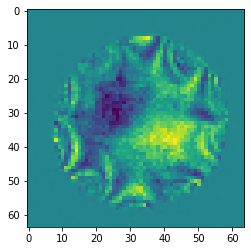

In [18]:
CBEDS = new_data.reshape(nysample, nxsample, nopix, nopiy)
plt.imshow(CBEDS[0,0,:,:])

Funtion to normalize data between 0 and 1

In [19]:
norm = lambda x: (x - x.min()) / x.ptp()

In [20]:
CBEDS = norm(CBEDS)

Center of Mass function

In [21]:
def COM(nysamp, nxsamp, nypix, nxpix, duin, dvin,CBED_in):
    from scipy import ndimage
    import math
    
    com_mag = np.zeros((nysamp, nxsamp))
    com_y = np.zeros((nysamp, nxsamp))
    com_x = np.zeros((nysamp, nxsamp))
    angle = np.zeros((nysamp, nxsamp))
    xyzero = np.zeros(2)
    xyzero = ndimage.measurements.center_of_mass(np.mean(CBED_in, axis=(0,1)) )   
#    xyzero[0] = nypix/2
#    xyzero[1] = nxpix/2
    
    for y in range(nysamp):
        for x in range(nxsamp):
            xycbed = ndimage.measurements.center_of_mass(CBED_in[y,x,:,:])
            com_x[y,x] = (xycbed[1]-xyzero[1])*duin
            com_y[y,x] = (xycbed[0]-xyzero[0])*dvin
            com_mag[y,x] = math.sqrt(com_y[y,x]*com_y[y,x]+com_x[y,x]*com_x[y,x])  
            
    angle = np.arctan2(com_y,com_x)  
    
    return com_y, com_x, angle, com_mag

Calculate COM

In [22]:
#default deflections in pixels:  Adjust for pixel size of CBED camera (including rescaling)
du =1.0
dv =1.0

com_y, com_x, angle, com_mag = COM(nysample, nxsample, nopiyout,nopixout,du,dv,CBEDS)

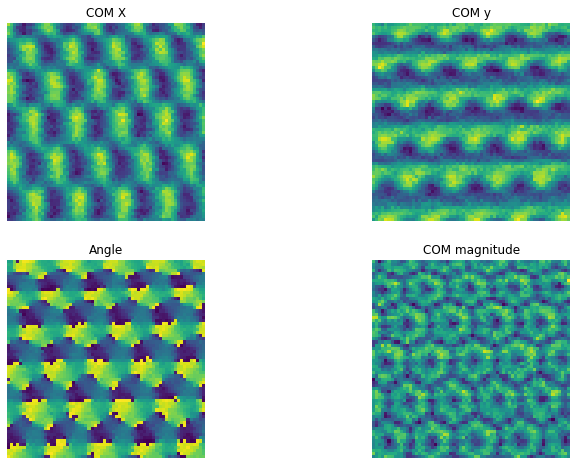

In [25]:
ncols = 2
nrows = 2
gs2 = gridspec.GridSpec(nrows, ncols)
fig2 = plt.figure(figsize = (12,8))

for i in range(4):
    if i == 0:
        ax2 = fig2.add_subplot(gs2[i])
        ax2.set_title('COM X')
        ax2.imshow(com_x)
        plt.axis('off')
    if i == 1:
        ax2 = fig2.add_subplot(gs2[i])
        ax2.set_title('COM y')
        ax2.imshow(com_y)
        plt.axis('off')
    if i == 2:
        ax2 = fig2.add_subplot(gs2[i])
        ax2.set_title('Angle')
        ax2.imshow(angle)
        plt.axis('off')
    if i == 3:
        ax2 = fig2.add_subplot(gs2[i])
        ax2.set_title('COM magnitude')
        ax2.imshow(com_mag)
        plt.axis('off')
        
    
plt.show()


# Create feaure array for rrVAE

In [26]:

feature_array = (CBEDS.reshape(nysample*nxsample, nopiy, nopix))


In [28]:
# make training/validation sets

from sklearn.model_selection import train_test_split
imstack_train, imstack_test = train_test_split(
    feature_array, test_size=0.15, shuffle=True, random_state=0)
print(imstack_train.shape, imstack_test.shape)

(3481, 64, 64) (615, 64, 64)


rrVAE

In [29]:
import atomai as aoi
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)
np.random.seed(0)

In [49]:
# Intitialize rVAE model
input_dim = (nopiy, nopix)

rrvae = aoi.models.rVAE(input_dim, latent_dim=2,
                        numlayers_encoder=2, numhidden_encoder=128,
                        numlayers_decoder=2, numhidden_decoder=128,
                        skip=False,translation = False) 

In [50]:
# now train
rrvae.fit(X_train=imstack_train, X_test=imstack_test, training_cycles=150, batch_size=20, loss="mse")

Epoch: 1/150, Training loss: 33.7084, Test loss: 14.4372
Epoch: 2/150, Training loss: 14.3148, Test loss: 13.7326
Epoch: 3/150, Training loss: 13.7015, Test loss: 13.2883
Epoch: 4/150, Training loss: 13.4680, Test loss: 13.2777
Epoch: 5/150, Training loss: 13.2516, Test loss: 12.8523
Epoch: 6/150, Training loss: 13.0264, Test loss: 12.7052
Epoch: 7/150, Training loss: 12.8179, Test loss: 12.5391
Epoch: 8/150, Training loss: 12.6330, Test loss: 12.2310
Epoch: 9/150, Training loss: 12.3411, Test loss: 11.9983
Epoch: 10/150, Training loss: 12.0981, Test loss: 11.8425
Epoch: 11/150, Training loss: 11.8987, Test loss: 11.5497
Epoch: 12/150, Training loss: 11.7229, Test loss: 11.3791
Epoch: 13/150, Training loss: 11.5476, Test loss: 11.3114
Epoch: 14/150, Training loss: 11.4149, Test loss: 11.2076
Epoch: 15/150, Training loss: 11.3799, Test loss: 11.0097
Epoch: 16/150, Training loss: 11.2802, Test loss: 10.9815
Epoch: 17/150, Training loss: 11.2142, Test loss: 10.9237
Epoch: 18/150, Training

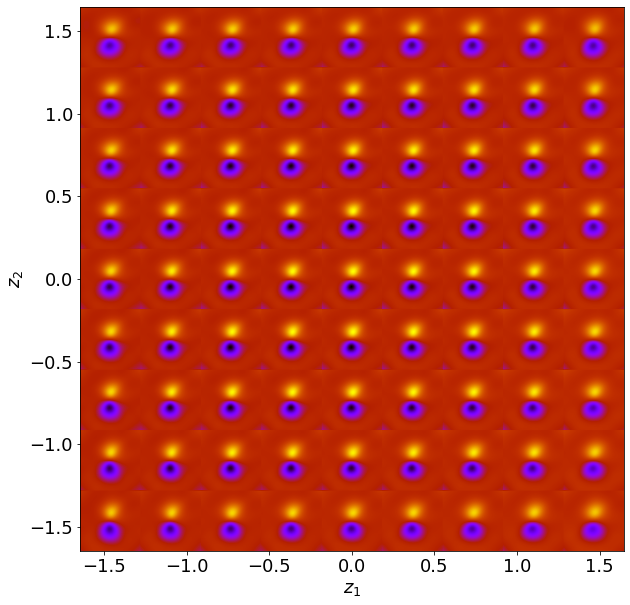

array([[0.49275559, 0.49487036, 0.49699873, ..., 0.50338453, 0.50187665,
        0.50036532],
       [0.49466735, 0.4967047 , 0.49875265, ..., 0.50505608, 0.50361729,
        0.5021711 ],
       [0.49651694, 0.4984749 , 0.50043857, ..., 0.50669771, 0.50533062,
        0.50395054],
       ...,
       [0.51804113, 0.51692814, 0.51584595, ..., 0.51542252, 0.51676154,
        0.51807177],
       [0.51976943, 0.51862568, 0.5175122 , ..., 0.51664019, 0.51812696,
        0.51957905],
       [0.5214628 , 0.52029163, 0.5191521 , ..., 0.51778477, 0.51941729,
        0.52101189]])

In [51]:
rrvae.manifold2d(cmap="gnuplot")

In [52]:
z_mean, z_sd = rrvae.encode(feature_array)

In [53]:
z_mean.shape

(4096, 3)

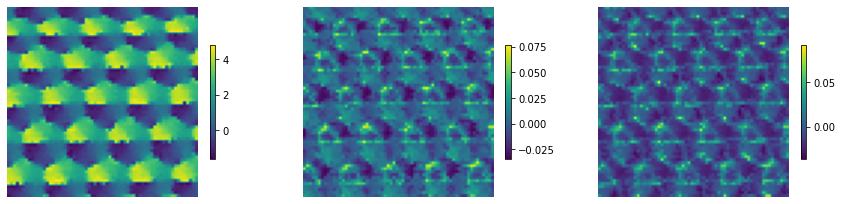

In [54]:
ncols = 3
nrows = 1
gs2 = gridspec.GridSpec(nrows, ncols)
fig2 = plt.figure(figsize = (15,3.5*nrows))

for i in range(3):
    ax2 = fig2.add_subplot(gs2[i])
    tmp = ax2.imshow(z_mean[:,i].reshape(nysample,nxsample), cmap='viridis')
    fig2.colorbar(tmp, ax = ax2, shrink = 0.6)
    plt.axis('off')
plt.show()
